In [1]:
%matplotlib inline

# Practical Work: Gene Regulatory Network Inference

### Gene Regulatory Networks

The control of the genes expression is operated to an important extent by transcription factors (TFs): these proteins can bind to the promoters and the enhancer of their target genes (TGs) to control their expression.
In practice, each TF and each TG is represented as a node in an oriented graph, and the regulatory interaction between a TF and a TG is modeled as a directed edge, between those nodes (from the TF to the TG).
The corresponding graph is denoted as the Gene Regulatory Network (GRN).
Understanding such networks, and analyzing their organization and their dynamics, are important steps towards the comprehension of complex mechanisms that shape living organisms.

### GRN inference
Inferring GRNs from high throughput sequencing data (e.g., RNAseq, Microarrays) is challenging complex problem, and different methods tackling this task have been proposed so far in the literature. These techniques can be classified in five major families:

+ correlation based methods
+ mutual Information based techniques
+ regression based methods 
+ bayesian inference algorithms
+ model based techniques (e.g. based on ODEs).

Each family presents its own advantages and biases, and each method may be more prone to detect particular kinds of regulatory interactions from the data. This phenomenon has been characterized by [Marbach et al., 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3512113/)

### Data

Many GRNI Algorithms take as an input a __gene expression matrix__. 
This matrix can be obtained by microarray (more common in the past) or RNAseq (more common now).
But, some recent methods (e.g. [pySCENIC](https://github.com/aertslab/pySCENIC)) also consider information such as transcription factor cis-regulatory sequences binding profiles, or other kinds of data such as CHIPseq data.

In this tutorial we are going to study the dataset provided in [Potier et al. 2014](https://www.sciencedirect.com/science/article/pii/S2211124714010043). In this study, the authors have inferred the GRN involved in Drosophila's eye development. To do so, the authors run 72 experiments of genetic perturbation, and recorded the corresponding RNAseq datasets. Then, to infer the GRN the authors used the GENIE3 algorithm, altogether with a correlation based method; and then they refined the results using a cis-regulatory motifs inference approach.

The final GRN inferred by the authors is [available online](http://eyenetwork.aertslab.org/download)

### Goal of this tutorial
The goal of this tutorial is to present you some basic steps of Gene Regulatory Network Inference (GRNI).

This tutorial focuses on the __GENIE3__ method (a machine learning regression based approach), and relies on `numpy`, `pandas` and `sklearn` python libraries.

The GENIE3 algorithm only uses a gene expression matrix.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the Gene Expression matrix

### Steps
The authors provided the RNAseq raw counts corresponding to their experiments. The following steps will:
+ Read the dataset
+ Drop NaN (rows without a "gene symbol")
+ Set the "Symbol" column as the index (name for each gene)
+ Delete columns that do not correspond to counts

In [3]:
X = pd.read_csv("GSE59059_all_network_experiments.countstable.txt",sep="\t")
# drop the genes that have no symbol (only 4) 
c = Counter(X.Symbol)
{ k: c[k] for k in c if c[k]>1}
X = X.dropna() 
# Set the index
X.index = X["Symbol"]
# Delete non-count columns
del X["ID"]
del X["Symbol"]
X.describe()

,Larval_brain_WT_RAL-208,Larval_brain_WT_cs,wing_imaginal_disc_WT_RAL-208_1-and-2_pooled,wing_imaginal_disc_WT_cs,eye-antennal_disc_RAL-80_GSM978988,eye-antennal_disc_cs_GSM978987,eye-antennal-imaginal-disc_GMR27H09-Gal4,eye-antennal-imaginal-disc_GMR-Gal4,eye-antennal-imaginal-disc_ato-Gal4,eye-antennal-imaginal-disc_sens-Gal4_x_UAS-GFP,...,eye-antennal-imaginal-disc_hs-Gal4_x_UAS-dfd,eye-antennal-imaginal-disc_ato-Gal4_x_UAS-repo,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dip3,eye-antennal-imaginal-disc_GMR-gal4_x_UAS-Lim3,eye-antennal-imaginal-disc_m4-Gal4_x_UAS-mam,eye-antennal-imaginal-disc_m4-Gal4_x_EP-danr,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dan,eye-antennal-imaginal-disc_m4-Gal4_x_EP-gbsN,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-lab,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-Su(H)
count,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,...,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000
mean,1311.319278,850.904523,265.178962,879.284606,782.075078,799.155370,886.443040,619.000261,767.474518,831.387122,...,1048.688282,650.349778,488.166254,499.890967,1021.687891,1140.607273,909.077294,893.204249,632.906999,560.539820
std,4482.976669,2986.855684,1216.288561,3570.659145,2946.427448,3074.458065,3420.261827,2308.404611,2855.369908,3241.210766,...,4346.937659,2454.062467,1991.275518,1870.338031,3866.536707,4580.551307,3448.262659,3423.441766,3045.236034,2047.680413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,135.000000,79.000000,6.000000,34.500000,65.000000,61.500000,58.000000,45.000000,40.000000,88.000000,...,42.000000,47.000000,15.000000,18.000000,45.000000,43.000000,33.000000,39.000000,36.000000,35.000000
75%,1019.000000,690.250000,178.000000,632.000000,582.000000,604.000000,660.000000,462.000000,571.000000,669.250000,...,777.250000,489.000000,367.000000,369.000000,763.000000,872.000000,667.000000,691.250000,451.000000,425.000000
max,181839.000000,121099.000000,61978.000000,193009.000000,164390.000000,163272.000000,169778.000000,122793.000000,142564.000000,177544.000000,...,254332.000000,130429.000000,97107.000000,102794.000000,210277.000000,253123.000000,181913.000000,177931.000000,187969.000000,102569.000000


# Normalize the Gene Expression Matrix
+ Normalizing the gene expression matrix is a crucial step, in order to avoid biases
+ The authors provide also a normalized version of the gene expression matrix (the edgeR and DEseq tools were used for this step)
+ In this tutorial we are going to:
    + load the normalized matrix
    + Normalize the raw counts matrix with the simple TPM method (Transcript per Million)

### Load normalized counts
The following steps allow to:
+ Read the dataset
+ Drop NaN (rows without a "gene symbol")
+ Set the "Symbol" column as the index (name for each gene)
+ Delete columns that do not correspond to counts

In [4]:
X_n = pd.read_csv("GSE59059_all_network_experiments.vst.txt",sep="\t")
X_n = X_n.dropna() # drop the genes that have no symbol (only 4) 
X_n.index = X_n["Symbol"]
del X_n["ID"]
del X_n["Symbol"]
X_n.describe()

,Larval_brain_WT_RAL-208,Larval_brain_WT_cs,wing_imaginal_disc_WT_RAL-208_1-and-2_pooled,wing_imaginal_disc_WT_cs,eye-antennal_disc_RAL-80_GSM978988,eye-antennal_disc_cs_GSM978987,eye-antennal-imaginal-disc_GMR27H09-Gal4,eye-antennal-imaginal-disc_GMR-Gal4,eye-antennal-imaginal-disc_ato-Gal4,eye-antennal-imaginal-disc_sens-Gal4_x_UAS-GFP,...,eye-antennal-imaginal-disc_hs-Gal4_x_UAS-dfd,eye-antennal-imaginal-disc_ato-Gal4_x_UAS-repo,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dip3,eye-antennal-imaginal-disc_GMR-gal4_x_UAS-Lim3,eye-antennal-imaginal-disc_m4-Gal4_x_UAS-mam,eye-antennal-imaginal-disc_m4-Gal4_x_EP-danr,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dan,eye-antennal-imaginal-disc_m4-Gal4_x_EP-gbsN,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-lab,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-Su(H)
count,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,...,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000
mean,-0.840838,-0.890370,-1.154324,-1.070635,-0.950445,-0.964736,-0.992847,-0.969950,-1.020576,-0.807466,...,-1.052272,-0.983180,-1.099672,-1.093867,-1.077244,-1.113105,-1.108023,-1.076484,-0.989718,-1.014103
std,2.145130,2.184834,2.393425,2.334373,2.173380,2.205648,2.245814,2.212533,2.290206,2.130240,...,2.364587,2.226537,2.355815,2.345557,2.342878,2.361499,2.373933,2.322389,2.240600,2.252617
min,-4.880919,-4.796233,-4.424084,-4.789733,-4.776593,-4.779583,-4.797973,-4.715468,-4.762305,-4.778696,...,-4.823150,-4.728333,-4.640305,-4.653407,-4.828815,-4.853300,-4.801042,-4.804387,-4.703549,-4.691168
25%,-2.423352,-2.563192,-3.496066,-3.226896,-2.657395,-2.715953,-2.867260,-2.750093,-3.016924,-2.392030,...,-3.203382,-2.771909,-3.361175,-3.297723,-3.223368,-3.310830,-3.340810,-3.227262,-2.953190,-2.915180
50%,-0.793749,-0.738349,-1.018226,-0.906449,-0.889066,-0.883735,-0.879591,-0.872205,-0.889465,-0.693910,...,-0.822833,-0.844530,-0.837782,-0.903611,-0.893770,-0.854429,-0.936840,-0.837921,-0.876806,-0.893894
75%,0.667700,0.651624,0.656870,0.651908,0.577695,0.619248,0.628649,0.614725,0.654647,0.693779,...,0.688676,0.610728,0.651054,0.629700,0.651288,0.632493,0.665344,0.638646,0.629027,0.624902
max,7.203294,7.206997,8.057643,7.920140,7.770683,7.742383,7.682865,7.707416,7.652237,7.868681,...,8.100203,7.722191,7.763539,7.779917,7.787623,7.884013,7.762662,7.709130,8.386874,7.580405


### TPM normalization
This is a simple normalization procedure that aims at:
+ Normalizing by the gene lengths
+ Normalizing by the sample (condition) depth
Let $X_{i,j}$ be the number of counts for gene $i$ in condition $j$, let $l_i$ be the length of the exonic part of gene $i$ (in base pairs). 

The TPM normalization proceeds as follows:
+ __Compute__ the Reads Per Kilobase (RPK) for each gene $i$ and each sample $j$: 
$$RPK_{i,j} = \frac{X_{i,j}}{\frac{l_i}{10^3}} = \frac{X_{i,j}}{l_i}\times 10^3$$

+ __Compute__ the Transcript Per Million (TPM) of each gene $i$ and each sample $j$: 
$$TPM_{i,j} = \frac{RPK_{i,j}}{\frac{\sum_i RPK_{i,j}}{10^6}} = \frac{RPK_{i,j}}{\sum_i RPK_{i,j}}\times 10^6 $$

In [5]:
#The following lines of code, aim at retrieving the exon lengths from the "gene_rpkm_report" dataset available at flybase.org, 
#please do not pay attention to this:
"""
a = pd.read_csv("gene_rpkm_report_fb_2015_03.tsv",sep="\t",comment="#",header=None)
a = a[[2,9]]
a.columns = ["Symbol","length"]
a = a.dropna()
a = a.drop_duplicates()
gb = a.groupby("Symbol")
lengths = gb.median()
lengths.to_csv("exon_gene_lengths.csv")
"""

'\na = pd.read_csv("gene_rpkm_report_fb_2015_03.tsv",sep="\t",comment="#",header=None)\na = a[[2,9]]\na.columns = ["Symbol","length"]\na = a.dropna()\na = a.drop_duplicates()\ngb = a.groupby("Symbol")\nlengths = gb.median()\nlengths.to_csv("exon_gene_lengths.csv")\n'

### Load the exonic gene size

In [6]:
lengths = pd.read_csv("exon_gene_lengths.csv",index_col=0)

### Apply the TPM normalization

In [8]:
l = lengths.loc[X.index]
l = l.fillna(l.mean())
RPK = pd.DataFrame(X.values * 1/ l.values,index=X.index,columns=X.columns) * 1e3
TPM = RPK * 1./ RPK.sum() * 1e6

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


### Apply a log transformation
Raw gene expression values tend to be skewed, to have a clear view on the gene expression data, it is often useful to apply a log scale transformation.
In this case, in order to prevent the computation of the logarithm of a null gene expression value, we add a small peudo-count $\epsilon \in \mathbb{R}^*_+$. Considering our TPM transformation:

$$logTPM_{i,j} = log(TPM_{i,j} +\epsilon)$$

In [9]:
epsilon = 1
logTPM = np.log10(TPM+epsilon)

### Plot the logarithm of the two normalized gene expression matrices
Two following plots show that the normalizations lead to similar results (visually), nevertheless an interesting idea would be to test the differences in terms of inference related to the normalization step.
+ logTPM normalized data

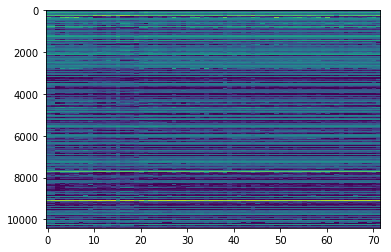

In [10]:
plt.imshow(logTPM.loc[X_n.index],aspect="auto")

+ Normalized data using edgeR and DEseq

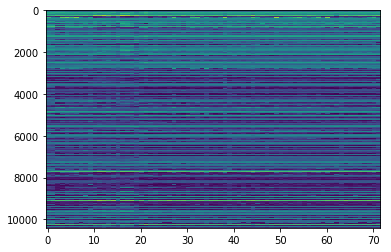

In [11]:
plt.imshow(X_n,aspect="auto")

# Select a subset of more expressed genes
For this tutorial, in order to reduce the runtimes, we are going to select a group of genes that are highly expressed, at least in one sample.

Therefore we focus on the most interesting genes, and we remove from our study those that are not very expressed in the different samples.

To do so, let us plot the histogram of the maximal expression for each gene

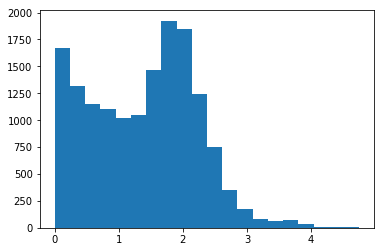

In [12]:
_=plt.hist(logTPM.max(axis=1),bins=20)

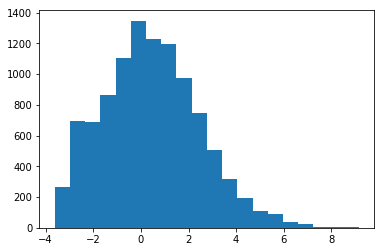

In [14]:
_=plt.hist(X_n.max(axis=1),bins=20)

In [15]:
X_ = logTPM[logTPM.max(axis=1)>1.5] 
X_.shape

(7645, 72)

# Get TF List

In [16]:
TF = pd.read_csv("list_TF.txt",header=None)[0].values

In [17]:
TF[:5]

array(['ab', 'abd-A', 'abd-B', 'abo', 'ac'], dtype=object)

In [18]:
len(TF)

816

# GENIE3 Algorithm
The [GENIE3 algorithm](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776), is a decision tree based GRN inference method, that belongs to the regression family.
This algorithm was proposed in 2010, and it has been the best method in the DREAM4 and DREAM5 (Dialogue for Reverse Engineering Assessments and Methods) challenges.  

Moreover this method does not rely on restrictive assumptions regarding the nature of the regulation, and it can deal with combinatorial and non-linear interactions.

In order to predict the GRN between $p$ genes, GENIE3 applies the following principle:

- The GRN inference problem is reduced to $p$ regression problems:
    - For each gene $i \in \{1,\dots,p\}$ use a Random Forest (tree-based ensemble method) to predict its expression pattern $X_{i,.}$ from the expression patterns of all the other genes $X_{j,.}, \forall j \in \{1,\dots,p\} \setminus \{i\} $
    - Then, the algorithm measures the __importance__ of each gene $j \in \{1,\dots,p\} \setminus \{i\}$ in the regression task. 
    - Then the importance of each gene $j \in \{1,\dots,p\} \setminus \{i\}$ in the prediction of the expression of gene $i$, is used to infer the regulation capability that gene $j$ may have over gene $i$.
    - In practice, it is not necessary to test the importance of each gene $j \in \{1,\dots,p\} \setminus \{i\}$, but only the importance of genes $j \in TF \setminus \{i\}$, where $TF$ denotes the set of genes that are likely to be transcription factors (which can be determined using gene annotation techniques). 
    - __Underlying hypothesis___: if the gene expression of a subset of TFs enables to model and predict correctly the expression of the target gene, then probably the target gene expression is in fact caused or directly influenced by the expression of the TFs that have been chosen.
    - Finally select the top-k links to have a GRN

### Computing feature importance with trees (side note, you can skip it)
There are different ways to compute the feature importance:
- Number of times a feature is used to split a node, weighted by the number of samples it splits
- Gini Importance - Mean Decrease in Impurity or Variance decrease: Sum of the gini (classification) or variance decrease (regression) over the splits (for all tress) which include the feature, weighted by the number of samples in the split (only version in sklearn).
- Permutation importance: Take one column at a time and permute the elements inside the column, compute the accuracy of the random forest before and after the permutation, the quality drop corresponds to the feature importance (https://explained.ai/rf-importance/index.html)
        
### Dimensionality reduction (side node, you can skip it --- for now)

Ranking genes according to their importance regarding the prediction of the expression of the target gene, corresponds to a dimensionality reduction task (more precisely to a feature selection task) $\to$ check the `Feature_selection_algorithms` notebook.

__IMPORTANT__: In order to understand better __regression trees__ and __random forests__, you can check the `regression_decision_tree` and the `random_forest` notebooks

In [25]:
from sklearn.ensemble import RandomForestRegressor
def genie3(expdata,
           tflist = None,
           targetlist=None,
           normalize=False,
           **rf_parameters):
    """
    + expdata: gene expression matrix, rows are samples (conditions) and columns are genes
    + tflist: list of transcription factors
    + targetlist: list of target genes
    + normalize: the gene expression of genes is z-scored
    + rf_parameters: dict containing the parameters of the random forest (feature selection algorithm)
    """
    # Set the list of TFs and TGs if necessary
    if targetlist is None:
        targetlist = expdata.columns
    if tflist is None:
        tflist = expdata.columns
    tflist_present = set(expdata.columns).intersection(tflist)
    targetlist_present = list(set(expdata.columns).intersection(targetlist))
    targetlist_present.sort()
    #  Normalize expression data for each gene
    if normalize:
        expdata = (expdata - expdata.mean()) / expdata.std()
    # compute tf stability scores for each gene
    scores_tf_per_gene = []
    # Create a RF classifier
    regr = RandomForestRegressor(**rf_parameters)
    for i, gene in enumerate(targetlist_present):
        # Exclude the current gene from the tfs list
        tfs2test = list(tflist_present.difference(set([gene])))
        tfs2test.sort()
        X = expdata[tfs2test]
        y = expdata[gene]
        # Train the Random Forest
        regr.fit(X, y)
        # Get the features importance (score for each TF -> Gene)
        scores = pd.Series(regr.feature_importances_,tfs2test)
        scores_tf_per_gene.append(scores)
        if(i%10==0):
            print(str(i)+"/"+str(len(targetlist_present)))
    df_results = pd.DataFrame(scores_tf_per_gene, index=targetlist_present)
    return(df_results)


#### Run the algorithm

In [28]:
#rf_parameters = {"n_estimators":500, "max_depth":3, "n_jobs":1, "max_features":None}
rf_parameters = {"n_estimators":10, "max_depth":3, "n_jobs":1, "max_features":None}
GRN = genie3(X_.T, TF, **rf_parameters)

0/7645
10/7645
20/7645
30/7645
40/7645
50/7645
60/7645
70/7645
80/7645
90/7645
100/7645
110/7645
120/7645
130/7645
140/7645
150/7645
160/7645
170/7645
180/7645
190/7645
200/7645
210/7645
220/7645
230/7645
240/7645
250/7645
260/7645
270/7645
280/7645
290/7645
300/7645
310/7645
320/7645
330/7645
340/7645
350/7645
360/7645
370/7645
380/7645
390/7645
400/7645
410/7645
420/7645
430/7645
440/7645
450/7645
460/7645
470/7645
480/7645
490/7645
500/7645
510/7645
520/7645
530/7645
540/7645
550/7645
560/7645
570/7645
580/7645
590/7645
600/7645
610/7645
620/7645
630/7645
640/7645
650/7645
660/7645
670/7645
680/7645
690/7645
700/7645
710/7645
720/7645
730/7645
740/7645
750/7645
760/7645
770/7645
780/7645
790/7645
800/7645
810/7645
820/7645
830/7645
840/7645
850/7645
860/7645
870/7645
880/7645
890/7645
900/7645
910/7645
920/7645
930/7645
940/7645
950/7645
960/7645
970/7645
980/7645
990/7645
1000/7645
1010/7645
1020/7645
1030/7645
1040/7645
1050/7645
1060/7645
1070/7645
1080/7645
1090/7645
1100/7645
1

# Get the edges of the GRN and rank them according to the RF importance
Fill NaN (NaN $\to$ self loops which are not processed by genie3)

In [29]:
GRN = GRN.fillna(0)

In [30]:
GRN_unstack = GRN.unstack(level=0)
GRN_rank = pd.DataFrame()
GRN_rank["rank"] = GRN_unstack.rank(method="dense",ascending=False)
GRN_rank["score"] = GRN_unstack
GRN_rank["TF"] = list(GRN_rank.index.get_level_values(level=0))
GRN_rank["TG"] = list(GRN_rank.index.get_level_values(level=1))
GRN_rank = GRN_rank.sort_values("score",ascending=False)

In [31]:
GRN_rank.head()

rank     score    TF       TG
sage CG43083   1.0  0.796132  sage  CG43083
     CG12715   2.0  0.769613  sage  CG12715
srp  CG14629   3.0  0.716497   srp  CG14629
sage CG43084   4.0  0.710068  sage  CG43084
trh  CG14566   5.0  0.700533   trh  CG14566

In [34]:
GRN_rank.to_csv("GRN_ranking_genie3_500trees_depth3.csv")

Text(0.5, 0, 'score')

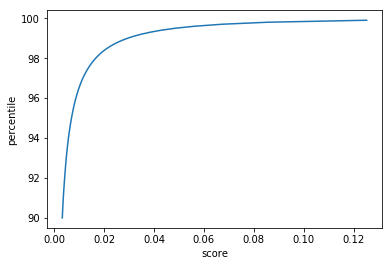

In [33]:
perc = np.arange(90,100,0.1)
plt.plot(np.percentile(GRN_rank["score"],perc),perc,"-")
plt.ylabel("percentile")
plt.xlabel("score")

# References and links
+ https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3512113/
+ https://academic.oup.com/bioinformatics/advance-article-abstract/doi/10.1093/bioinformatics/bty916/5184284?redirectedFrom=fulltext
+ https://github.com/aertslab/pySCENIC
+ http://eyenetwork.aertslab.org/download
+ https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776